# Project Workflow

#### Identify Engaged and unengaged users
In the current notebook, I shall be using the transactions dataset for identifying engaged users from unenagaged users. I use the days since last transaction of a given user to label her as an unengaed or engaged user.

#### Feature extraction for engaged user classification
In this notebook titled `FeatureExtractionEngagedClassification.ipynb` I shall be performing some EDA and preparing the dataset for classifying a user an engaged or unengaged. I treat this a binary classification problem. 

#### Model building for classifying engaged vs unengaged users
In this final notebook titled `ModelTrainerUserEngagement.ipynb`, I shall be using using the XGBoost library for classifying engaged vs unengaged users. The notebook will also list the relevant metrics and feature importances for the classification problem.

The 3 notebooks above constitute a DAG which can be run in the same order as listed.

#### AB testing
The final notebook `ABTesting.ipynb` provides the methodology and metric for AB testing the efficacy of the buisness action to retain the users most likely to churn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import seaborn as sns
style.use('ggplot')
from IPython.display import display, HTML
from pylab import rcParams
%matplotlib inline

## Transactions
Read the transactions dataset

In [2]:
transactions = pd.read_csv("data/rev-transactions.csv")
transactions['created_date'] = pd.to_datetime(transactions['created_date'])
transactions.head()

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,user_5509,2019-03-22 05:42:50.316652


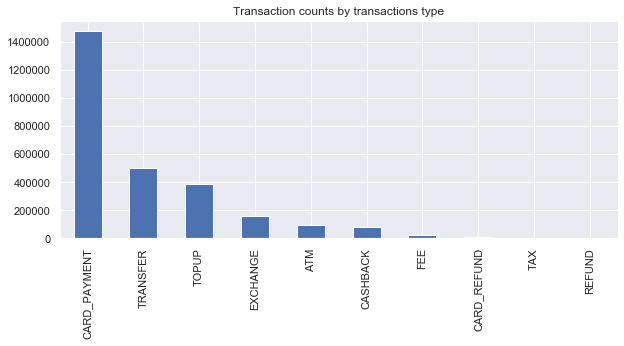

In [3]:
sns.set(rc={'figure.figsize': (10, 4)})
fig, axes = plt.subplots()
txt = transactions.transactions_type.value_counts(dropna=False).plot(
    kind="bar", ax=axes).set_title("Transaction counts by transactions type")

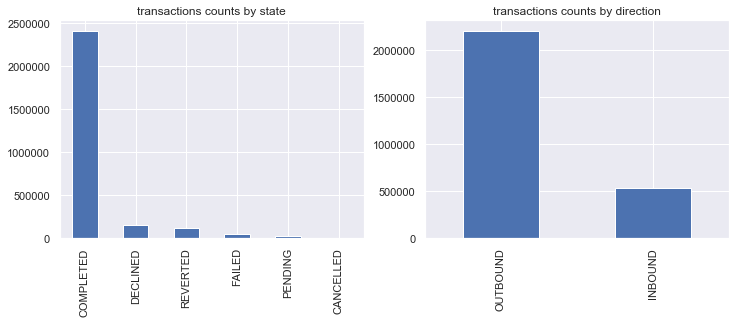

In [4]:
sns.set(rc={'figure.figsize': (12, 4)})
fig, axes = plt.subplots(nrows=1, ncols=2)
transactions.transactions_state.value_counts(dropna=False).plot(
    kind="bar", ax=axes[0]).set_title("transactions counts by state")
txt = transactions.direction.value_counts(dropna=False).plot(
    kind="bar", ax=axes[1]).set_title("transactions counts by direction")

### Aggregate metrics per user

I shall be using the column `days_since_last_valid_trans` which represents the number of days since any transaction carried out by a user as the primary feature for tagging a user an engaged or unengaged.
Note that I initially though that maybe I should consider only transaction which DO NOT fall under declined or failed but decided against it since this a buisness decision that I do not have any knowledge on.

In [5]:
last_transaction_date = transactions.created_date.max()


def transaction_stats_by_user(group):
    days_since_last_trans = (last_transaction_date - group.created_date.max()).days
    return pd.Series({"days_since_last_valid_trans": days_since_last_trans,
                      "number_of_trans": len(group),
                      "transaction_mean": group.amount_usd.mean(),
                      "transaction_min": group.amount_usd.min(),
                      "transaction_max": group.amount_usd.max(),
                      "completed_pending_count":len(
                         group[group.transactions_state.isin(["COMPLETED","PENDING"])]),
                      "other_state_count":len(
                         group[~group.transactions_state.isin(["COMPLETED","PENDING"])])
                      
                     })


trans_stats_user = transactions.groupby("user_id").apply(
    transaction_stats_by_user)
trans_stats_user.reset_index(inplace=True)
trans_stats_user.head()

,user_id,days_since_last_valid_trans,number_of_trans,transaction_mean,transaction_min,transaction_max,completed_pending_count,other_state_count
0,user_0,14.0,389.0,35.176787,0.00,582.18,350.0,39.0
1,user_1,78.0,129.0,47.316899,0.00,350.00,114.0,15.0
2,user_10,5.0,1053.0,49.525109,0.00,2947.24,847.0,206.0
3,user_100,9.0,133.0,156.224211,0.55,709.21,110.0,23.0
4,user_1000,324.0,39.0,552.944615,1.00,1000.03,35.0,4.0


## Statistics for `days_since_last_valid_trans`

We can clearly see that this follows an exponential distribution. 

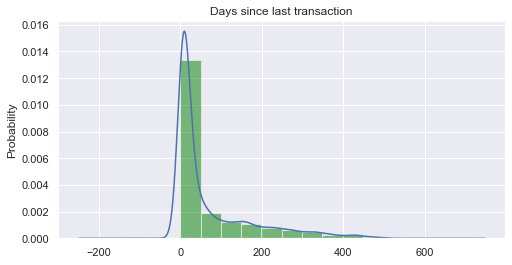

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
days_since_last_valid_trans = trans_stats_user.days_since_last_valid_trans
days_since_last_valid_trans.plot.kde(ax=ax, legend=False,
                                     title=f'Days since last transaction')
days_since_last_valid_trans.plot.hist(density=True, ax=ax, color="green", alpha=0.5)
ax.set_ylabel('Probability')
ax.grid(True)

### PDF and CDF for the `days_since_last_valid_trans`
The mean inter arrival rate between transactions between users is $69.865$ days.

69.86576787807738


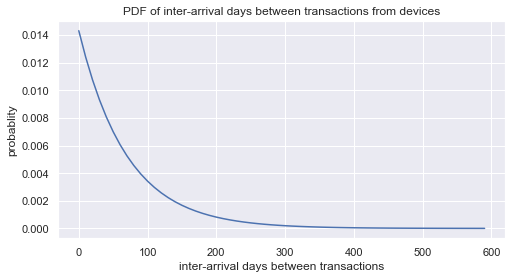

In [7]:
mean_iat = days_since_last_valid_trans.mean()
print(mean_iat)

lamda = 1/mean_iat
x = []
y = []
for day in np.arange(0, 600, 10):
    x.append(day)
    y.append(lamda*np.exp(-day*lamda))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.set_ylabel('probablity')
ax.set_xlabel('inter-arrival days between transactions')
ax.set_title("PDF of inter-arrival days between transactions from devices")
ax.grid(True)

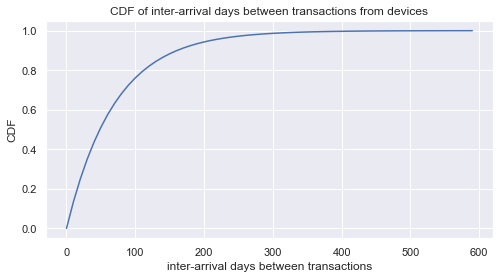

In [8]:
x = []
y = []
for day in np.arange(0, 600, 10):
    x.append(day)
    y.append(1.0 -np.exp(-day*lamda))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.set_ylabel('CDF')
ax.set_xlabel('inter-arrival days between transactions')
ax.set_title("CDF of inter-arrival days between transactions from devices")
ax.grid(True)

### Tagging enaged vs unengaed users
The CDF above shows that nearly 80% of the users make atleast 1 trasaction within 115 days. I have chosen 80% percent as the cut off for tagging engaed vs unengaed users. Note that I can also choose a 90% cutoff, but this is a buisness decision to be taken with consulation from a product team.

In [9]:
1.0 -np.exp(-(115)*lamda)

0.8071829643041545

In [10]:
trans_stats_user.loc[trans_stats_user.days_since_last_valid_trans >= 115, "status"]="unengaged"
trans_stats_user.loc[trans_stats_user.days_since_last_valid_trans < 115, "status"]="engaged"


In [17]:
print("Days since last transaction for unengaged users",trans_stats_user[trans_stats_user.status ==
                  "unengaged"].days_since_last_valid_trans.mean())
print("Days since last transaction for engaged users",trans_stats_user[trans_stats_user.status ==
                 "engaged"].days_since_last_valid_trans.mean())

Days since last transaction for unengaged users 236.31794003868472
Days since last transaction for engaged users 22.80861244019139


### Saving the aggregate metrics for model building
Note that I am excluding the column `days_since_last_valid_trans` which was used for tagging engaged and unengaged users as a feature to prevent overfitting while classifying engaed and unengaed users.

In [11]:
trans_stats_user[trans_stats_user.status=="unengaged"].drop(
    ["days_since_last_valid_trans","status"],axis=1).to_csv(
    "unengaged_users.csv", index=False)

trans_stats_user[trans_stats_user.status=="engaged"].drop(
    ["days_since_last_valid_trans","status"],axis=1).to_csv(
    "engaged_users.csv", index=False)